# P6 - Catégorisez automatiquement des questions

## Importation des librairies

In [1]:
# Librairies classiques
import pandas as pd
import numpy as np
import pickle
from time import time

# Librairies graphiques
import matplotlib.pyplot as plt
%matplotlib inline

# Librairies de traitement de texte
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Méthodes d'import export
import pickle
from sklearn.externals import joblib
CT_DIR = '../autotag/save/'

def load_obj(name):
    with open(CT_DIR + name + '.pkl', 'rb') as f:
        return pickle.load(f)


## Récupération des données

In [3]:
df_train = pd.read_csv(CT_DIR + 'df_train.csv')
df_test = pd.read_csv(CT_DIR + 'df_test.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)
dataraw = df_train.append(df_test)
print(dataraw.shape)
dataraw.head()

dataraw = dataraw.sample(10000)

(152855, 2)
(38214, 2)
(191069, 2)


In [5]:
all_tags_loaded = load_obj('all_tags')

# Pour noter les topics trouvés on va récupérer les mots des tags sans les tirets
all_tags = []
for word in all_tags_loaded:
    for w in word.split('-'):
        if len(w)>1:
            all_tags.append(w)
all_tags = sorted(set(all_tags))

# Réduction dimensionnelle

In [35]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [36]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    print('n=',n_components)
    return n_components

In [37]:
# Vectorizer
t0 = time()
max_df=.8
min_df=5
max_features=10000
vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
tf = vect.fit_transform(dataraw['TextCleaned'])
print("Vectorizer done in %0.3fs." % (time() - t0))

Vectorizer done in 0.836s.


In [42]:
# Conduct LDA
t0 = time()
lda = LinearDiscriminantAnalysis(n_components=None)
lda.fit(tf)
print("LDA done in %0.3fs." % (time() - t0))
select_n_components(lda.explained_variance_ratio_, 0.95)

TypeError: fit() missing 1 required positional argument: 'y'

In [40]:
# Conduct PCA
t0 = time()
pca = PCA(n_components=0.95, whiten=True)
X_pca = pca.fit_transform(tf.toarray()) # Pas sparse
print("PCA done in %0.3fs." % (time() - t0))
print('Original number of features:', tf.shape[1])
print('Reduced number of features:', X_pca.shape[1])

PCA done in 159.702s.
Original number of features: 5172
Reduced number of features: 1249


In [41]:
# Conduct TSVD
t0 = time()
tsvd = TruncatedSVD(n_components=tf.shape[1]-1)
X_tsvd = tsvd.fit(tf)
print("TruncatedSVD done in %0.3fs." % (time() - t0))
select_n_components(tsvd.explained_variance_ratio_, 0.95)

TruncatedSVD done in 243.936s.
n= 1249


1249

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        print('n_components =', str(n))
        pca.n_components = n
        fa.n_components = n
        t0 = time()
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        print("PCA Done in %0.3fs." % (time() - t0))
        t0 = time()
        fa_scores.append(np.mean(cross_val_score(fa, X)))
        print("FA Done in %0.3fs." % (time() - t0))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


def ReduceDim(X, title, n_components):
    t0 = time()
    pca_scores, fa_scores = compute_scores(X)
    print("compute_scores Done in %0.3fs." % (time() - t0))
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

#    t0 = time()
#    pca = PCA(svd_solver='full', n_components='mle')
#    pca.fit(X)
#    n_components_pca_mle = pca.n_components_
#    print("PCA mle Done in %0.3fs." % (time() - t0))

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
#    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    rank = 10
    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % 10, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

    plt.show()

n_components = 45
PCA Done in 471.611s.
FA Done in 109.899s.
compute_scores Done in 581.510s.
best n_components by PCA CV = 45
best n_components by FactorAnalysis CV = 45


NameError: name 'n_components_pca_mle' is not defined

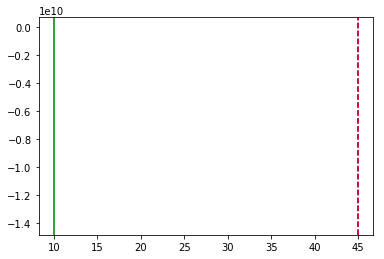

In [55]:
t0 = time()
n_components = np.arange(45, 50, 5)  # options for n_components
ReduceDim(tf.toarray(), 'Dimensional reduction', n_components)
print("Done in %0.3fs." % (time() - t0))

# Mode non supervisé - Analyse de Title+Body

On va maintenant essayer d'extraire des clusters de notre nouvelle feature, d'abord avec LDA ensuite avec NMF

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

mystops = set(stopwords.words("english"))

In [24]:
no_topics = 50
no_top_words = 5

# Méthode d'affichage des mots clés de chaque groupe
def display_topics(model, feature_names, name, no_top_words, display=True):
    total_matches = 0
    for topic_idx, topic in enumerate(model.components_):
        if display: print ("Topic %d " % (topic_idx), end=' ')
        topic_top_words_index = topic.argsort()[:-no_top_words - 1:-1]
        n = 0
        for i in topic_top_words_index:
            if feature_names[i] in all_tags:
                n += 1
        total_matches += n
        if display: print ("(%d matchs) :" % (n), end=' ')
        if display: print (" ".join([feature_names[i] for i in topic_top_words_index]))
    nmax = no_topics * no_top_words
    note = total_matches/nmax
    print("Note=%.2f, explained_variance_ratio_=%.2f (%d matches sur %d possibles - %s)" % (note, model.explained_variance_ratio_, total_matches, nmax, name))
    return note

def score(vect, mod, name, display=False):
    t0 = time()
    tf = vect.fit_transform(dataraw['TextCleaned'])
    
    mod.fit(tf)
    if display: print("done in %0.3fs." % (time() - t0))
    note = display_topics(mod, vect.get_feature_names(), name, no_top_words, display=display)
    
    if display: 
        print()
        predict = mod.transform(tf)
        for n in range(10):
            topic_most_pr = predict[n].argmax()
            print("doc {}, topic {}, {}...".format(n, topic_most_pr, dataraw.TextCleaned.iloc[n][:50]))
    
    return note

## LDA

In [25]:
# LDA avec CountVectorizer

def scoreLDA(max_df, min_df, max_features, display=False):
    vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')

    mod = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', 
                                    learning_offset=50., random_state=0)
    name = 'LDA max=%.1f - min=%i - feat=%i' % (max_df, min_df, max_features)
    return score(vect, mod, name, display)

## NMF

In [26]:
# NMF avec TfidfVectorizer

def scoreNMF(max_df, min_df, max_features, loss='frobenius', display=False):
    vect = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
    
    mod = NMF(n_components=no_topics, alpha=.1, l1_ratio=.5, beta_loss=loss, solver='mu', max_iter=200, random_state=0)
    name = 'NMF max=%.1f - min=%i - feat=%i' % (max_df, min_df, max_features)
    return score(vect, mod, name, display)

## Comparaison

In [10]:
no_topics = 15
no_top_words = 10
t0 = time()
print("MIN")
p_min = [5, 10, 20]
for m in p_min:
    scoreLDA(.8, m, 10000)
    scoreNMF(.8, m, 10000)
print("MAX")
p_max = [.5, .8, .9]
for m in p_max:
    scoreLDA(m, 5, 10000)
    scoreNMF(m, 5, 10000)
print("FEATURES")
p_feat = [1000, 10000, 100000]
for m in p_feat:
    scoreLDA(.8, 5, m)
    scoreNMF(.8, 5, m)

print("NMF loss")
scoreNMF(.8, 5, 10000, loss='frobenius')
scoreNMF(.8, 5, 10000, loss='kullback-leibler')

print("done in %0.3fs." % (time() - t0))

MIN
Note=0.79 (118 matches sur 150 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.81 (122 matches sur 150 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.81 (122 matches sur 150 possibles - LDA max=0.8 - min=10 - feat=10000)
Note=0.80 (120 matches sur 150 possibles - NMF max=0.8 - min=10 - feat=10000)
Note=0.82 (123 matches sur 150 possibles - LDA max=0.8 - min=20 - feat=10000)
Note=0.78 (117 matches sur 150 possibles - NMF max=0.8 - min=20 - feat=10000)
MAX
Note=0.76 (114 matches sur 150 possibles - LDA max=0.5 - min=5 - feat=10000)
Note=0.79 (119 matches sur 150 possibles - NMF max=0.5 - min=5 - feat=10000)
Note=0.79 (118 matches sur 150 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.81 (122 matches sur 150 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.79 (118 matches sur 150 possibles - LDA max=0.9 - min=5 - feat=10000)
Note=0.81 (122 matches sur 150 possibles - NMF max=0.9 - min=5 - feat=10000)
FEATURES
Note=0.79 (118 matches sur 150 possibles - LDA max=0.8 

In [11]:
no_topics = 50
no_top_words = 5
t0 = time()
print("MIN")
p_min = [5, 10, 20]
for m in p_min:
    scoreLDA(.8, m, 10000)
    scoreNMF(.8, m, 10000)
print("MAX")
p_max = [.5, .8, .9]
for m in p_max:
    scoreLDA(m, 5, 10000)
    scoreNMF(m, 5, 10000)
print("FEATURES")
p_feat = [1000, 10000, 100000]
for m in p_feat:
    scoreLDA(.8, 5, m)
    scoreNMF(.8, 5, m)

print("NMF loss")
scoreNMF(.8, 5, 10000, loss='frobenius')
scoreNMF(.8, 5, 10000, loss='kullback-leibler')

print("done in %0.3fs." % (time() - t0))

MIN
Note=0.72 (179 matches sur 250 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.75 (187 matches sur 250 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.72 (180 matches sur 250 possibles - LDA max=0.8 - min=10 - feat=10000)
Note=0.76 (191 matches sur 250 possibles - NMF max=0.8 - min=10 - feat=10000)
Note=0.72 (181 matches sur 250 possibles - LDA max=0.8 - min=20 - feat=10000)
Note=0.77 (193 matches sur 250 possibles - NMF max=0.8 - min=20 - feat=10000)
MAX
Note=0.73 (183 matches sur 250 possibles - LDA max=0.5 - min=5 - feat=10000)
Note=0.79 (197 matches sur 250 possibles - NMF max=0.5 - min=5 - feat=10000)
Note=0.72 (179 matches sur 250 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.75 (187 matches sur 250 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.72 (179 matches sur 250 possibles - LDA max=0.9 - min=5 - feat=10000)
Note=0.75 (187 matches sur 250 possibles - NMF max=0.9 - min=5 - feat=10000)
FEATURES
Note=0.74 (186 matches sur 250 possibles - LDA max=0.8 

In [12]:
# Détail du meilleur modèle
no_topics = 15
no_top_words = 10
scoreLDA(.8, 5, 10000, display=True)

done in 568.550s.
Topic 0  (9 matchs) : string public new class return method object code privat null
Topic 1  (8 matchs) : tabl id sql queri select column data mysql record insert
Topic 2  (8 matchs) : div style width text css height color class li font
Topic 3  (8 matchs) : date 10 00 report time number 2009 format excel valu
Topic 4  (6 matchs) : user server servic client use messag databas web applic send
Topic 5  (7 matchs) : java connect python org modul import file plugin eclips sourc
Topic 6  (10 matchs) : form control text asp javascript function id html page tag
Topic 7  (9 matchs) : class object list valu type use array like way item
Topic 8  (7 matchs) : use like way code need know look work question time
Topic 9  (5 matchs) : xml session lib rubi schema rail cach http encod element
Topic 10  (8 matchs) : file window use run applic project test instal work net
Topic 11  (10 matchs) : file page http web com php site url use request
Topic 12  (8 matchs) : imag thread draw loc

0.7866666666666666

In [13]:
no_topics = 50
no_top_words = 5
scoreNMF(.5, 5, 10000, display=True)

done in 43.219s.
Topic 0  (4 matchs) : code like way work know
Topic 1  (3 matchs) : valu properti type return set
Topic 2  (3 matchs) : tabl column databas row sql
Topic 3  (4 matchs) : button click event jqueri dialog
Topic 4  (4 matchs) : file directori folder upload path
Topic 5  (5 matchs) : asp net mvc web site
Topic 6  (4 matchs) : string charact public convert return
Topic 7  (2 matchs) : class public interfac privat properti
Topic 8  (5 matchs) : project visual studio 2008 build
Topic 9  (5 matchs) : server sql connect error 2005
Topic 10  (2 matchs) : imag png jpg background img
Topic 11  (4 matchs) : servic web wcf client soap
Topic 12  (4 matchs) : test unit run mock nunit
Topic 13  (3 matchs) : net vb framework ado entiti
Topic 14  (5 matchs) : field html valid input type
Topic 15  (4 matchs) : object properti type serial collect
Topic 16  (5 matchs) : list sort collect item element
Topic 17  (4 matchs) : page load html aspx web
Topic 18  (3 matchs) : java eclips jar org l

0.788

In [14]:
for t in all_tags:
    if t[0]=='v':
        print (t)

v1.0
v2.0
v3
v3p2
v4.5
v4l2
v8
vacuum
vala
valgrind
valid
validate
validating
validation
validationerror
validationrules
validationsummary
validator
validators
value
valuechangelistener
valueconverter
valued
values
var
varbinary
varchar
varchar2
variable
variables
variadic
variance
variant
varnish
varray
vars
vary
vault
vax
vb.net
vb5
vb6
vba
vbc
vbcodeprovider
vbe
vbo
vbscript
vbulletin
vbx
vc6
vc8
vcal
vcalendar
vcard
vcbuild
vcdiff
vcf
vcl
vcl4php
vcproj
vcs
vdi
vdproj
vds
vector
vectorization
vectormath
velocity
vendor
vendors
venn
verbatim
verbosity
verification
verifier
verify
verifyerror
verilog
verity
verizon
versant
version
versioned
versioninfo
versioning
versions
vertex
vertical
vertices
verysleepy
vexing
vfs
vfw
vga
vhd
vhdl
vhosts
vi
vibrate
video
video4linux
videodisplay
videoview
viemu
view
viewbox
viewdata
viewdidload
viewengine
viewer
viewexpiredexception
viewmodel
viewpage
viewport
viewport3d
viewresult
views
views2
viewstack
viewstate
viewusercontrol
vignette
vim
vim

In [15]:
len(all_tags)

11379

In [16]:
## GridSearch

from sklearn.model_selection import GridSearchCV

vect = CountVectorizer(max_df=.8, min_df=5, max_features=10000, stop_words='english')
tf = vect.fit_transform(dataraw['TextCleaned'])

# Define Search Param
search_params = {'n_components': [10, 30, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


In [17]:
# Do the Grid Search
model.fit(tf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 30, 50], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 30}
Best Log Likelihood Score:  -15291375.1208
Model Perplexity:  1150.11059227


In [22]:
best_lda_model.n_components

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=30, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [23]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(dataraw))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0,0,0,0.01,0.02,0.67,0,0.03,0,0,0,0,0.01,0,0,0,0,0.2,0,0,0,0,0,0,0,0,0,0,0.03,6
Doc1,0,0,0,0,0,0.13,0,0,0,0,0,0,0.6,0.19,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,12
Doc2,0,0,0,0,0,0,0,0.06,0,0,0,0.64,0.24,0,0,0.02,0,0.02,0,0,0,0.01,0,0,0,0,0,0,0,0.01,11
Doc3,0,0.02,0,0,0.01,0.04,0,0.27,0.05,0,0.25,0,0.26,0,0,0,0.04,0,0,0.03,0,0,0,0.01,0,0,0,0,0,0,7
Doc4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0,0,0,0,0.91,0,0.02,0,26
Doc5,0,0,0,0.66,0.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0,0,0,0,0,0,0,0,0,3
Doc6,0,0,0,0,0,0,0,0,0,0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2,0,9
Doc7,0,0,0,0,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.06,0,0.1,0,0,0,4
Doc8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08,0,0.08,0,0,0,0,0,0,0.09,0,0.73,0,28
Doc9,0,0,0,0.02,0,0,0,0,0,0,0,0,0.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,12


In [24]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,12,25728
1,18,6754
2,13,5750
3,26,5645
4,6,5155
5,23,4446
6,20,3553
7,17,3409
8,29,3268
9,24,3182
